# Project 4: Web Scraping Job Postings
----
### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

**Determine the industry factors that are most important in predicting the salary amounts for these data.**

**Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?**

To limit the scope, your principal has suggested that you focus on data-related job postings, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by limiting your search to a single region.

Hint: Aggregators like Indeed.com regularly pool job postings from a variety of markets and industries.

----
**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.

**Directions**
In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to answer the two questions described above.

---

In [1]:
# Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup as Soup
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
from selenium import webdriver
from selenium.webdriver.chrome.options import Options


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score


from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

from scipy import stats
from scipy.stats import skew

import nltk
from gensim import corpora, models, matutils
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


import urllib, requests, re
from time import sleep

pd.set_option('max_colwidth',500)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hilmijohari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Strategy
--------------
**Objective : Build a model using mycareersfuture information that predicts job salary**

### Method: 
- **Scrape mycareersfuture titles, jobs descriptions, company names and salaries** (performed using scrapy - selector (this method worked best with mycareersfuture.com))

- **Scrape indeed.com titles, jobs descriptions, company names and salaries** (performed using Beautiful soup - selenium (this method worked best with indeed.com))

- **Perform data cleaning on both datasets**:
    - Cleaning dataframe: 
        - Lowercase all characters,remove non characters (text) and symbols (dollar values)
        - Remove jobs that do not meet criteria (i.e job has no description, title, company, or salary)
        
    - Extract job seniority (using keywords)
   
    - Group job titles by job type (using keywords)
    
    - Cleaning Job Salaries 
        - remove jobs with no salaries
        - Convert to numerical values, average salaries to new column
        - Transform salaries as monthly salaries
        - verify transformations
        - Rectify skew of salaries (log salary values)


- **NLP text transformation**
    - Generate stop words list (english stop words + common description words)
    - Perform 1) PorterStemmer or 2) WordNetLemmatizer (new columns)
    - Perform CountVectorizer + Tfif Transformer (TfidVectorizer) on descriptions, job title & companies
    - Dummify the job seniority
    - Make new dataframe with the transformed data
    
    
- **Exploratory Data Analysis**
    - Salaries according to Job Title
    - Salaries according to Seniority
    - PCA to visualize distribution of dataset.  
    
    
- **Model Selection for Linear Regression**
    - Base Model: LinearRegression
    - Regularization Models: Ridge, Lasso
    - Robust Models: HuberRegressor
   

- **Validate model using mycareersfuture test set**
    - Identify features with high coefs (positive and negative)
    
    
- **Predict salaries for indeed.com jobs**
    - Compare average salaries mycareersfuture by seniority/ job type versus predicted at indeed.com
    - Compare similar job at mycareersfuture versus indeed.com


**Scraping MyCareersFuture with Scrapy - Gathering Job Title, Company, Job Description & Salary**

In [2]:
chrome_options = Options()
chrome_options.add_argument("--headless")
chromedriver = "./chromedriver_win32/chromedriver.exe"


def get_links(site):
    for num in range(0,300):
        driver = webdriver.Chrome(chromedriver, options = chrome_options)
        page = driver.get(site.format(num))
        sleep(3)
        html = driver.page_source
        for x in range (0,19):
            for a in driver.find_elements_by_xpath('//*[@id="job-card-{}"]/div/a'.format(x)):
                links_mcf.append(a.get_attribute('href'))

        if num % 10 == 0:
            print('Number of pages completed: {}'.format(num))
    
links_mcf = []

get_links('https://www.mycareersfuture.sg/search?search=data&postingCompany=Direct&sortBy=new_posting_date&page={}')

links_mcf= [link for link in set(links_mcf)]
print('Number of links gatherered: {}'. format(len(links_mcf)))

Number of pages completed: 0
Number of pages completed: 10
Number of pages completed: 20
Number of pages completed: 30
Number of pages completed: 40
Number of pages completed: 50
Number of pages completed: 60
Number of pages completed: 70
Number of pages completed: 80
Number of pages completed: 90
Number of pages completed: 100
Number of pages completed: 110
Number of pages completed: 120
Number of pages completed: 130
Number of pages completed: 140
Number of pages completed: 150
Number of pages completed: 160
Number of pages completed: 170
Number of pages completed: 180
Number of pages completed: 190
Number of pages completed: 200
Number of pages completed: 210
Number of pages completed: 220
Number of pages completed: 230
Number of pages completed: 240
Number of pages completed: 250
Number of pages completed: 260
Number of pages completed: 270
Number of pages completed: 280
Number of pages completed: 290
Number of links gatherered: 4162


In [ ]:
# links to csv
df_links_mcf = pd.DataFrame(links_mcf, columns = ['links'])
df_links_mcf.to_csv('links_mcf.csv')

In [10]:
df_links_mcf.head()

,links
0,https://www.mycareersfuture.sg/job/lead-engineer-propertyguru-4b8c7eb3813b949162103ee68453a9a4
1,https://www.mycareersfuture.sg/job/junior-senior-rd-thermal-engineer-lite-on-singapore-bb69b9cc580695833d5081df5becc05c
2,https://www.mycareersfuture.sg/job/senior-strategist-tbwa-singapore-5557babe04dbb5c96e438180094d1ffc
3,https://www.mycareersfuture.sg/job/actuarial-assistant-c3e1aedd1924306509f1e767d2380217
4,https://www.mycareersfuture.sg/job/lead-document-controller-tuff-offshore-engineering-services-5d59e8421a002101dc541ab002dcba1c


In [12]:
def parsing_links(links_mcf): 
    for link in links_mcf:
        driver = webdriver.Chrome(chromedriver, options = chrome_options)
        driver.get(link)
        sleep(3)
        html = driver.page_source

        job_title = Selector(text = html).xpath('//h1[@id = "job_title"]//text()').extract()
        if len(job_title) == 0:    
            job_titles.append('None')
        else:
            job_titles.append(job_title[0])
        
# Name of hiring company:
        company = Selector(text = html).xpath('//p[@name = "company"]//text()').extract()
        if len(company) == 0:    
            companies.append('None')
        else:
            companies.append(company[0])
    
# Minimum and maximum salaries
        salary = Selector(text = html).xpath('//span[@class = "dib"]//text()').extract()
        if len(salary) == 0:
            min_salaries.append('None')
            max_salaries.append('None')
        else: 
            min_salaries.append(salary[0])
            max_salaries.append(salary[2])


# Full Job description
        description = Selector(text=html).xpath('//div[@class ="jobDescription w-100 v-top relative"]//text()').extract()
        if len(description) == 0:
            descriptions.append('None')
        else:
            descriptions.append((str.join(' ', description)))            
        
        if len(descriptions) % 100 == 0:
            print('Number of Job links parsed: {}'.format(len(descriptions)))

job_titles = []
companies = []
min_salaries = []
max_salaries = []
descriptions = []

parsing_links(links_mcf[0:2000]) 

Number of Job links parsed: 100
Number of Job links parsed: 200
Number of Job links parsed: 300
Number of Job links parsed: 400
Number of Job links parsed: 500
Number of Job links parsed: 600
Number of Job links parsed: 700
Number of Job links parsed: 800
Number of Job links parsed: 900
Number of Job links parsed: 1000
Number of Job links parsed: 1100
Number of Job links parsed: 1200
Number of Job links parsed: 1300
Number of Job links parsed: 1400
Number of Job links parsed: 1500
Number of Job links parsed: 1600
Number of Job links parsed: 1700
Number of Job links parsed: 1800
Number of Job links parsed: 1900
Number of Job links parsed: 2000


In [20]:
# Add collected information to a dataframe
df_mcf = pd.DataFrame(np.column_stack([job_titles, descriptions, companies, min_salaries, max_salaries]), 
                               columns=['job_titles','descriptions', 'companies', 'min_salaries', 'max_salaries'])

In [21]:
# Store into a CSV file.
df_mcf.to_csv('data_mcf.csv', index=False)

In [2]:
df_mcf = pd.read_csv('./data_mcf.csv')

In [3]:
#With duplicates
print('Number of entries without cleaning: {}'.format(df_mcf.shape[0]))
df_mcf['job_titles'].unique()

#Cleaning DataSet
# 1 drop duplicates
df_mcf = df_mcf.drop_duplicates(inplace=False)
df_mcf = df_mcf[df_mcf['min_salaries'] != 'None']
df_mcf = df_mcf[df_mcf['max_salaries'] != 'None']
print('Number of entries with cleaning: {}'.format(df_mcf.shape[0]))

Number of entries without cleaning: 2000
Number of entries with cleaning: 1576


**Scraping Indeed.com with Beautiful Soup - Gathering Job Title, Company, Job Description & Salary**

In [49]:
def get_links_indeed(site):
    for i in range(1, 21):
        num = (i-1) * 50
        base_url = site.format(num)
        page = requests.get(base_url)
        soup = Soup(page.text, 'lxml')
    
        jobs = soup.find_all('div', {'class':'row'})
        
        for div in jobs:
            link = div.find('div', {'class': 'title'})
            p_url = link.a.get('href')
            links_in.append('https://ca.indeed.com' + p_url)
            
    #Page Counter
    print('Number of pages completed: {}'.format(i))

links_in = []            
get_links_indeed('https://www.indeed.com.sg/jobs?q=data+(scientist+or+analyst+or+analytics+or+machine+or+learning+or+deep+or+learning+or+business+or+intelligence)+-marketing&l=Singapore&limit=50&sr=directhire&st=employer&radius=10&start={}')


links_in = [link for link in set(links_in)]
print('Number of links gatherered: {}'. format(len(links_in)))

Number of pages completed: 20
Number of links gatherered: 1031


In [50]:
linkin = pd.DataFrame(links_in, columns = ['links'])
linkin.to_csv('linkin.csv')

In [2]:
linkin = pd.read_csv('linkin.csv')
links_in = list(linkin['links'])

In [4]:
def indeed_parsing(links):
    for link in links:
        sleep(5)
        url = link
        page = requests.get(url)
        if page.status_code == 200:
            soup = Soup(page.text, 'lxml')
            jobs = soup.find_all('div', {'class':'jobsearch-JobComponent icl-u-xs-mt--sm'})
            for div in jobs:
        
                for job_title in div.find_all('h3' , {'class' : 'icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title'}):
                    titles_in.append(job_title.text)
            
                for info in div.find_all('div', {'class' : 'jobsearch-jobDescriptionText'}):
                    descriptions_in.append(info.text)
            
                for comp in div.find_all('div', {'class' : 'icl-u-lg-mr--sm icl-u-xs-mr--xs'}):
                    if comp.text != '-':
                        companies_in.append(comp.text)
                
                x = div.find_all('span', {'class' : 'jobsearch-JobMetadataHeader-iconLabel'})
                try: 
                    salaries_in.append(x.text)
                except:
                    salaries_in.append('None')
            
                # Link counter
                if len(descriptions_in) % 100 == 0:
                    print('Number of Job links parsed: {}'.format(len(descriptions_in)))
        else: 
            pass
    
titles_in = []
companies_in = []
descriptions_in = []
salaries_in = []

indeed_parsing(links_in)   

Number of Job links parsed: 100
Number of Job links parsed: 200
Number of Job links parsed: 300
Number of Job links parsed: 400
Number of Job links parsed: 500
Number of Job links parsed: 600
Number of Job links parsed: 700
Number of Job links parsed: 800
Number of Job links parsed: 900
Number of Job links parsed: 1000


In [4]:
#Place into a DataFrame
df = pd.DataFrame(np.column_stack([titles_in, descriptions_in, companies_in,salaries_in]), 
                               columns=['job_titles','descriptions', 'companies', 'salaries'])

# Store into a CSV file.
df.to_csv('data.csv', index=False)


In [4]:
df = pd.read_csv('./data.csv')

In [5]:
#With duplicates
print('Number of entries without cleaning: {}'.format(df.shape[0]))
df['job_titles'].unique()

#Cleaning DataSet
# 1 drop duplicates
df = df.drop_duplicates(inplace=False)
print('Number of entries with cleaning: {}'.format(df.shape[0]))

Number of entries without cleaning: 1027
Number of entries with cleaning: 913


### Question 1: Factors that impact salary
To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:

NLP
Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
Ensemble methods and decision tree models
SVM models
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. Communication of your process is key. Note that most listings DO NOT come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

---

**Cleaning DataFrame**
---

In [6]:
def cleaning_df(dataframe):
    
    for column_name in dataframe:
    #all dataframe to lowercase
        dataframe[column_name] = dataframe[column_name].apply(lambda x : x.lower())
    
    # Removing all characters that are not alphabethical in the description, title and company.
        if (column_name != 'min_salaries') and (column_name != 'max_salaries'):
            dataframe[column_name] =  dataframe[column_name].apply(lambda x : re.sub(r'[^a-zA-Z]', " ", x))
    
    # Removing all characters that are not numbers in the salary.       
        if (column_name == 'min_salaries') or (column_name == 'max_salaries'):
            dataframe[column_name] =  dataframe[column_name].apply(lambda x : re.sub(r'[^\d.]', '', x))

        
    dataframe.replace(to_replace='None',value = np.nan, inplace = True) 
    
    dataframe.dropna(axis = 0, inplace = True)

cleaning_df(df_mcf)
cleaning_df(df)

**Job Seniority Extraction**
---

In [7]:
intern_kw = ['internship', 'intern']
manager = ['lead', 'senior','manager', 'sr', 'mgr']
officer = ['technician', 'officer','assistant']
junior = ['junior', 'graduate']
top = ['head', 'avp', 'partner', 'director', 'vp', 'coo' ]

In [8]:
def job_seniority(x): 
        
    #Managers
    for m in manager:
        if x.__contains__(m) == True:
            return 'senior_manager'  
        
    #Academics 
    for o in officer :
        if x.__contains__(o) == True:
            return 'officer'
        
    # Top
    for t in top:
        if x.__contains__(t) == True:
            return 'c_level'
        
    for j in junior:
        if x.__contains__(j) == True:
            return 'junior'
        
    # Internships
    for i in intern_kw:
        if x.__contains__(i) == True:
            return 'intern'

    else:
        return 'executive'

df['seniority'] = df['job_titles'].apply(job_seniority)
df_mcf['seniority'] = df_mcf['job_titles'].apply(job_seniority)

#manual corrections:
df_mcf.loc[719, 'seniority'] = 'executive'

print('Jobs by seniority Indeed.com {}'.format(df['seniority'].value_counts()))
print('Jobs by seniority MyCareersFuture {}'.format(df_mcf['seniority'].value_counts()))

Jobs by seniority Indeed.com executive         445
senior_manager    316
intern             61
officer            46
c_level            32
junior             13
Name: seniority, dtype: int64
Jobs by seniority MyCareersFuture executive         833
senior_manager    487
officer           161
c_level            75
junior             17
intern              3
Name: seniority, dtype: int64


**Grouping Job Titles By Type**
---

In [9]:
# Lists of Keywords to sort jobs into groups
data_kw = ['data', 'analytics','analyst', 'machine', 'scientist', 'science']
business_kw = ['operations', 'business','operation','strategy', 'consultant','consulting', 'strategist']
academic_kw =['student', 'scientist', 'graduate', 'lecturer', 'research', 'chemist', 'chemical', 'learning', 'college', 'instructor', 'education', 'fellow']
financial_kw = ['banking', 'wealth', 'financial', 'sales', 'risk', 'finance', 'payments', 'investments','investment', 'payroll', 'accountant', 'actuarial', 'credit', 'transaction', 'e-billing', 'giro', 'sales']
admin_kw = ['administrative', 'assistant', 'admin', 'human', 'hr', 'customer', 'talent', 'client', 'recruitment', 'recruiting', 'recruiter', 'product']
management_kw = ['project', 'manager', 'management', 'mgr', 'supply chain']
other_tech_kw = ['software', 'developer', 'ui/ux', 'tech', 'technology', 'technologies', 'technological', 'engineering', 'engineer', 'it', 'digital']

In [10]:
def title_summary(x):
    # Data analytics
    for da_terms in data_kw:
        if x.__contains__(da_terms) == True:
            return 'data_job' 
        
    #business analyst
    for bus_term in business_kw:
        if x.__contains__(bus_term) == True:
            return 'BA_&_consultant'  
        
    #Academics 
    for ac_terms in academic_kw :
        if x.__contains__(ac_terms) == True:
            return 'academics'

    # Financial
    for fin_term in financial_kw :
        if x.__contains__(fin_term) == True:
            return 'finances'
        
    # Assistant
    for adm in admin_kw:
        if x.__contains__(adm) == True:
            return 'administration'
        
    #Management
    for man_term in management_kw:
        if x.__contains__(man_term) == True:
            return 'management'
        
    #Other technological careers
    for tech_term in other_tech_kw:
        if x.__contains__(tech_term) == True:
            return 'other_tech_career'  
 
    else:
        return 'unclassified'

df['title_short'] = df['job_titles'].apply(title_summary)
df_mcf['title_short'] = df_mcf['job_titles'].apply(title_summary)

print('Jobs by categories Indeed.com {}'.format(df['title_short'].value_counts()))
print('Jobs by categories MyCareersFuture {}'.format(df_mcf['title_short'].value_counts()))

Jobs by categories Indeed.com data_job             393
BA_&_consultant      118
administration        96
unclassified          92
other_tech_career     77
academics             58
finances              47
management            32
Name: title_short, dtype: int64
Jobs by categories MyCareersFuture data_job             326
other_tech_career    321
administration       216
unclassified         201
management           156
BA_&_consultant      147
finances             111
academics             98
Name: title_short, dtype: int64


**Cleaning Job Salaries**
---

In [11]:
# Remove none salaries
df_mcf = df_mcf[df_mcf['min_salaries'] != '']

In [12]:
df_mcf['min_salaries'] = pd.to_numeric(df_mcf['min_salaries'])
df_mcf['max_salaries'] = pd.to_numeric(df_mcf['max_salaries'])

In [13]:
# use value 
df_mcf['mean_salaries'] = df_mcf[['min_salaries','max_salaries']].mean(axis = 1)

In [14]:
for row in df_mcf.index:
    for sen in ['junior', 'officer', 'intern']:
        if (df_mcf.loc[row,'seniority'] == sen) & (df_mcf.loc[row,'mean_salaries'] >= 10000):
            df_mcf.loc[row,'mean_salaries'] = df_mcf.loc[row,'mean_salaries']/ 12
            
    if (df_mcf.loc[row,'seniority'] == 'executive') & (df_mcf.loc[row,'mean_salaries'] >= 20000):
        df_mcf.loc[row,'mean_salaries'] = df_mcf.loc[row,'mean_salaries']/ 12
    
    for sen in ['c_level', 'senior_manager']:
        if (df_mcf.loc[row,'seniority'] == sen) & (df_mcf.loc[row,'mean_salaries'] >= 50000):
            df_mcf.loc[row,'mean_salaries'] = df_mcf.loc[row,'mean_salaries']/ 12

In [15]:
df_mcf.groupby('seniority').mean()

,min_salaries,max_salaries,mean_salaries
seniority,,,
c_level,15216.666667,23898.213333,10054.662222
executive,6357.198079,9968.986795,5350.239696
intern,1033.333333,1383.333333,1208.333333
junior,4788.235294,7623.529412,4588.235294
officer,2835.403727,4195.167702,2555.632505
senior_manager,7981.687885,12500.193018,7429.566136


In [16]:
df_mcf[df_mcf['seniority'] == 'junior'][['companies','job_titles', 'mean_salaries']]

,companies,job_titles,mean_salaries
138,hubble pte ltd,junior data scientist,5350.0
160,streetsine singapore pte ltd,junior data analyst,4000.0
229,lucasfilm animation company singapore b v,junior creature td artist,4500.0
501,robert half international pte ltd,md jqd junior qlikview developer,5500.0
552,tum create limited,junior computer vision engineer for deep learning applied to real world robotic system,4000.0
672,traveloka services pte ltd,junior mid level data engineer,4500.0
853,cartrack technologies south east asia pte ltd,junior data scientist,7500.0
968,observational and pragmatic research institute pte ltd,junior data analyst,3500.0
1158,ubisoft singapore pte ltd,junior d level artist,4750.0
1436,omron asia pacific pte ltd,junior it analyst application support ms sql,3150.0


**Rectify the skew in mean salaries**

Skew of Salaries without modification: 1.2957846904834358


Text(0.5, 0, 'Mean Salary no transformation')

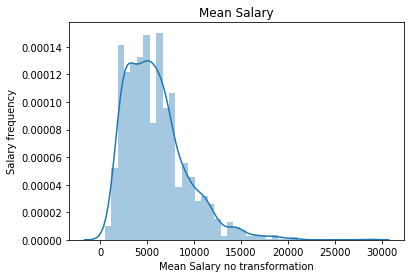

In [17]:
#skewed salary distribution
print('Skew of Salaries without modification: {}'.format(skew(df_mcf['mean_salaries'])))
sns.distplot(df_mcf['mean_salaries'])
plt.title('Mean Salary')
plt.ylabel('Salary frequency')
plt.xlabel('Mean Salary no transformation')

Skew of Salaries with log10 transformation: -0.29253419840743383


Text(0.5, 0, 'Mean Salary Log10 transformed')

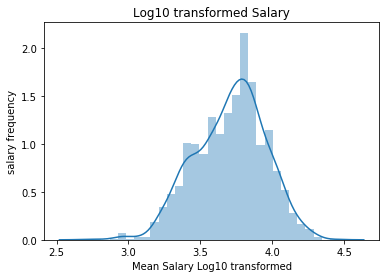

In [18]:
# log transform salaries
df_mcf['mean_salaries_log'] = df_mcf['mean_salaries'].apply(lambda x : np.log10(x))
print('Skew of Salaries with log10 transformation: {}'.format(skew(df_mcf['mean_salaries_log'])))
sns.distplot(df_mcf['mean_salaries_log'])
plt.title('Log10 transformed Salary')
plt.ylabel('salary frequency')
plt.xlabel('Mean Salary Log10 transformed')

Skew of Salaries with log10 transformation: -0.007750757536205787


Text(0.5, 0, 'Mean Salary Box-Cox transformed')

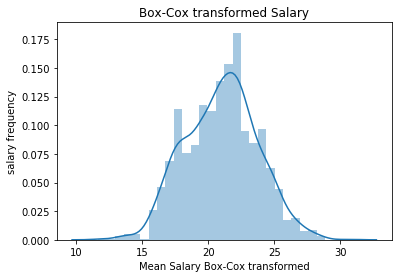

In [19]:
df_mcf['mean_salaries_bc']  = stats.boxcox(df_mcf['mean_salaries'])[0]
print('Skew of Salaries with log10 transformation: {}'.format(skew(df_mcf['mean_salaries_bc'])))
sns.distplot(df_mcf['mean_salaries_bc'])
plt.title('Box-Cox transformed Salary')
plt.ylabel('salary frequency')
plt.xlabel('Mean Salary Box-Cox transformed')

**NOTE : Use Box-Cox transformed values for salary**

**Categories of Salaries**

In [20]:
df_mcf.drop(columns = ['min_salaries','max_salaries', 'mean_salaries', 'mean_salaries_log'], inplace = True)

# NLP text transformation

In [32]:
# entries: 0 to 1574 are my careersfuture
# entries from 1575 to 2488 are indeed.com

In [21]:
df.drop(columns = 'salaries', inplace = True)
df['mean_salaries_bc'] = 0

In [22]:
full_df = pd.concat([df_mcf, df], axis = 0)

In [33]:
full_df.reset_index(drop = True, inplace = True)

**Generate stop words list using NLTK**
--

In [35]:
# Stop words to be added
characters_to_replace = ['requirements', 'required', 'roles', 'responsibilities', 'job', 'summary', 'skills', 'experience', 'description', 'key', 'singapore'
                       'qualifications', 'company', 'role', 'experience', 'knowledge', 'education', 'required', 'function', 'undisclosed', 'ltd', 'pte', 'asia']

stop_words = stopwords.words('english')
stop_words += characters_to_replace

**Stemming Words using PorterStemmer & WordNetLemmatizer**
----

In [36]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df_mcf['descriptions_pstemmed'] = df_mcf['descriptions'].apply(stem_sentences)
full_df['descriptions_pstemmed'] = full_df['descriptions'].apply(stem_sentences)

In [37]:
lemmatizer = WordNetLemmatizer() 

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df_mcf['descriptions_lemm'] = df_mcf['descriptions'].apply(stem_sentences)
full_df['descriptions_lemm'] = full_df['descriptions'].apply(stem_sentences)

In [38]:
# Descriptions converted for mycareersfuture.com jobs
df_mcf[['descriptions', 'descriptions_pstemmed', 'descriptions_lemm']].head(1)

,descriptions,descriptions_pstemmed,descriptions_lemm
0,roles responsibilities design and implement efficient scalable and maintainable cross cut functionalities for the platform design and implement infrastructure necessary to support the implemented functionality we are deploying to aws and adapting kubernetes using jenkins quite a lot to automate delivery pipeline set up guidelines and processes for engineers to ensure consistent architecture across various applications help and coach development teams on application and data ...,role respons design and implement effici scalabl and maintain cross cut function for the platform design and implement infrastructur necessari to support the implement function we are deploy to aw and adapt kubernet use jenkin quit a lot to autom deliveri pipelin set up guidelin and process for engin to ensur consist architectur across variou applic help and coach develop team on applic and data design work with legaci code to adapt it to use cross cut function our technolog stack includ but...,role responsibility design and implement efficient scalable and maintainable cross cut functionality for the platform design and implement infrastructure necessary to support the implemented functionality we are deploying to aws and adapting kubernetes using jenkins quite a lot to automate delivery pipeline set up guideline and process for engineer to ensure consistent architecture across various application help and coach development team on application and data design work with legacy code...


In [40]:
# Descriptions coverted for indeed.com jobs
full_df[['descriptions', 'descriptions_pstemmed', 'descriptions_lemm']].tail(1)

,descriptions,descriptions_pstemmed,descriptions_lemm
2488,position buyer job description job duties may include but are not limited to directing and overseeing purchasing operation of the business unit overseeing and leading the work of a group of buyers and sales follow up and manage daily req offers oem excess proactive offers manage inventory allocation and control co ordinate incoming outgoing shipments with qa and logistics compile data relating to supplier performance to enable evaluation score card review assess and evalua...,posit buyer job descript job duti may includ but are not limit to direct and overse purchas oper of the busi unit overse and lead the work of a group of buyer and sale follow up and manag daili req offer oem excess proactiv offer manag inventori alloc and control co ordin incom outgo shipment with qa and logist compil data relat to supplier perform to enabl evalu score card review assess and evalu supplier and contribut to perform review analys excess list to evalu opportun for end of life o...,position buyer job description job duty may include but are not limited to directing and overseeing purchasing operation of the business unit overseeing and leading the work of a group of buyer and sale follow up and manage daily req offer oem excess proactive offer manage inventory allocation and control co ordinate incoming outgoing shipment with qa and logistics compile data relating to supplier performance to enable evaluation score card review ass and evaluate supplier and contribute to...


**Word Counts & Frequencies**
---
Tried both no stemming, porterstemming and lemminization transformed descriptions. Selected Lemminization due to better r2 score. 

**Job Descriptions**

In [43]:
vect_1 = TfidfVectorizer(stop_words = stop_words, min_df = 2, ngram_range = (1,3), norm = 'l2')
d_vector = vect_1.fit_transform(df_mcf['descriptions_lemm'])

d_trans = pd.DataFrame(d_vector.todense(),columns=vect_1.get_feature_names())
print('Word Frequency # features: {}.'.format(d_trans.shape[1]))

word_counts = d_trans.sum(axis = 0)
print('top 10 words with frequency for mycareersfuture.com')
word_counts.sort_values(ascending = False).head(10)

Word Frequency # features: 87477.
top 10 words with frequency for mycareersfuture.com


data           43.298722
business       37.186760
team           35.882446
work           30.977056
project        30.792883
skill          30.489073
system         30.035482
management     29.878008
customer       28.260181
requirement    27.319513
dtype: float64

In [44]:
vect_2 = TfidfVectorizer(stop_words = stop_words, min_df = 2, ngram_range = (1,3), norm = 'l2')
d_vector_in = vect_2.fit_transform(full_df['descriptions_lemm'])

d_trans_in = pd.DataFrame(d_vector_in.todense(),columns=vect_2.get_feature_names())
print('Word Frequency # features: {}.'.format(d_trans_in.shape[1]))

word_counts_in = d_trans_in.sum(axis = 0)
print('top 10 words with frequency for full dataset')
word_counts_in.sort_values(ascending = False).head(10)

Word Frequency # features: 150903.
top 10 words with frequency for full dataset


data           68.029131
business       59.866466
team           56.244423
work           46.369438
skill          44.065339
management     43.685449
project        43.444832
customer       40.798066
system         40.556688
requirement    38.177970
dtype: float64

**Job titles**

In [45]:
vector_3 = TfidfVectorizer(stop_words = stop_words, min_df = 2, ngram_range = (1,3),norm = 'l2')
jb_vector = vector_3.fit_transform(df_mcf['job_titles'])

jb_trans = pd.DataFrame(jb_vector.todense(),columns=vector_3.get_feature_names())
print('Word Frequency # features: {}.'.format(jb_trans.shape[1]))

word_counts_jb = jb_trans.sum(axis = 0)
print('top 10 words with frequency in job title for mycareersfuture.com')
word_counts_jb.sort_values(ascending = False).head(10)


Word Frequency # features: 1145.
top 10 words with frequency in job title for mycareersfuture.com


engineer      79.431535
manager       70.750700
senior        57.216651
data          53.600063
analyst       47.800730
executive     46.793132
assistant     44.715804
research      33.946608
developer     28.166935
consultant    27.809119
dtype: float64

In [46]:
vector_4 = TfidfVectorizer(stop_words = stop_words, min_df = 2, ngram_range = (1,3),norm = 'l2')
jb_vector_in = vector_4.fit_transform(full_df['job_titles'])

jb_trans_in = pd.DataFrame(jb_vector_in.todense(),columns=vector_4.get_feature_names())
print('Word Frequency # features: {}.'.format(jb_trans.shape[1]))

word_counts_jb_in = jb_trans_in.sum(axis = 0)
print('top 10 words with frequency in job title for full dataset')
word_counts_jb_in.sort_values(ascending = False).head(10)

Word Frequency # features: 1145.
top 10 words with frequency in job title for full dataset


data              101.813138
senior             94.451738
engineer           91.944258
analyst            90.347307
manager            85.306958
executive          63.066767
scientist          58.026476
assistant          55.755397
data scientist     51.971389
business           49.720782
dtype: float64

**Companies**

In [47]:
vector_5 = TfidfVectorizer(stop_words = stop_words, min_df = 2, ngram_range = (1,3),norm = 'l2')
co_vector = vector_5.fit_transform(df_mcf['companies'])

co_trans = pd.DataFrame(co_vector.todense(),columns=vector_5.get_feature_names())
print('Word Frequency # features: {}.'.format(co_trans.shape[1]))

word_counts_co = co_trans.sum(axis = 0)
print('top 10 words with frequency in companies for mycareersfuture.com')
word_counts_co.sort_values(ascending = False).head(10)

Word Frequency # features: 902.
top 10 words with frequency in companies for mycareersfuture.com


singapore        125.890459
limited           43.858090
pacific           39.569941
international     30.773940
services          29.839099
university        27.904906
bank              24.458003
solutions         21.148331
dbs               20.114703
dbs bank          20.114703
dtype: float64

In [48]:
vector_6 = TfidfVectorizer(stop_words = stop_words, min_df = 2, ngram_range = (1,3),norm = 'l2')
co_vector_in = vector_6.fit_transform(full_df['companies'])

co_trans_in = pd.DataFrame(co_vector_in.todense(),columns=vector_6.get_feature_names())
print('Word Frequency # features: {}.'.format(co_trans_in.shape[1]))

word_counts_co_in = co_trans_in.sum(axis = 0)
print('top 10 words with frequency in companies for full dataset')
word_counts_co_in.sort_values(ascending = False).head(10)

Word Frequency # features: 1284.
top 10 words with frequency in companies for full dataset


singapore        141.163704
limited           46.352402
pacific           41.805455
university        37.871903
bank              37.596510
services          35.813304
national          30.530521
international     30.230923
dbs               29.727363
dbs bank          29.727363
dtype: float64

**New DataFrame with the Transformed data**
---

In [49]:
# MY CAREERS FUTURE.COM DATAFRAME
#Dummify the seniority:
categories = df_mcf[['seniority']]
categories = pd.get_dummies(categories, drop_first = True)

#Reset all indexes
categories.reset_index(drop = True, inplace = True)
d_trans.reset_index(drop = True, inplace = True)
jb_trans.reset_index(drop = True, inplace = True)
co_trans.reset_index(drop = True, inplace = True)

#Concatenate all the dataframes
new_df = pd.concat([categories, jb_trans, d_trans, co_trans], axis = 1)
print('Number of Columns for mycareersfuture.com : {}'.format(new_df.shape[1]))

Number of Columns for mycareersfuture.com : 89529


In [50]:
# FULL DATAFRAME

#Dummify the seniority:
categories_in = full_df[['seniority']]
categories_in = pd.get_dummies(categories_in, drop_first = True)

#Reset all indexes
categories.reset_index(drop = True, inplace = True)
d_trans_in.reset_index(drop = True, inplace = True)
jb_trans_in.reset_index(drop = True, inplace = True)
co_trans_in.reset_index(drop = True, inplace = True)

#Concatenate all the dataframes
new_df_in = pd.concat([categories_in, jb_trans_in, d_trans_in, co_trans_in], axis = 1)
print('Number of Columns for Full DataFrame : {}'.format(new_df_in.shape[1]))

Number of Columns for Full DataFrame : 154069


**Visualizing Data**
---

(10, 25)

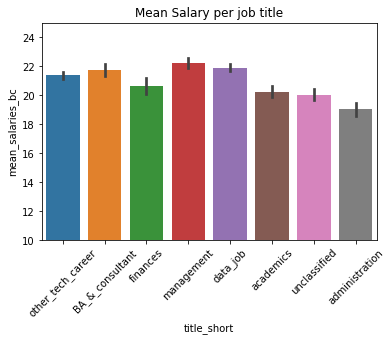

In [54]:
#By Job Title
sns.barplot(x = 'title_short', y = 'mean_salaries_bc', data = df_mcf)
plt.xticks(rotation = 45)
plt.title('Mean Salary per job title')
plt.ylim(10,25)

Text(0.5, 1.0, 'Mean Salary per seniority')

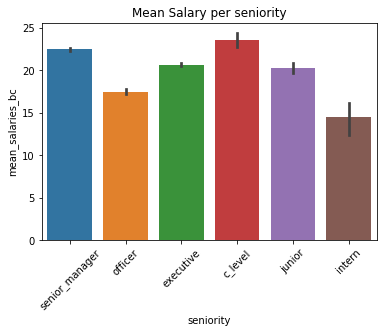

In [56]:
#By Job Title
sns.barplot(x = 'seniority', y = 'mean_salaries_bc', data = df_mcf)
plt.xticks(rotation = 45)
plt.title('Mean Salary per seniority')

**PCA - visualizing distribution of jobs**

In [219]:
# remove my indeed.com values
X = new_df_in.iloc[0:1576,:]
X.shape

(1576, 154069)

In [220]:
y = df_mcf['mean_salaries_bc']
y.shape

(1576,)

In [221]:
# Split data 90 : 10
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 42)

In [108]:
#Do PCA here
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(X.values)
data_pca = pca.transform(X.values)
pca_comp = pca.components_

In [110]:
df_pca = pd.DataFrame(data_pca,columns=['PC'+str(i) for i in range(1, data_pca.shape[1]+1)])
df_pca['seniority'] = df_mcf['seniority']
df_pca['title_short'] = df_mcf['title_short']
comp_1 = pd.Series(pca.components_[0], index=new_df_in.columns)
comp_2 = pd.Series(pca.components_[1], index=new_df_in.columns)

In [111]:
comp_1.sort_values(ascending = False).head(10)

seniority_senior_manager    0.650078
manager                     0.094805
senior                      0.065954
seniority_officer           0.061337
assistant                   0.022771
lead                        0.022462
project manager             0.018836
singapore                   0.017822
project                     0.017302
senior engineer             0.012385
dtype: float64

In [112]:
comp_2.sort_values(ascending = False).head(10)

seniority_officer     0.737362
assistant             0.175406
officer               0.087472
technician            0.043238
research assistant    0.037159
accounts assistant    0.035642
accounts              0.031885
admin                 0.030582
university            0.030323
admin assistant       0.028053
dtype: float64

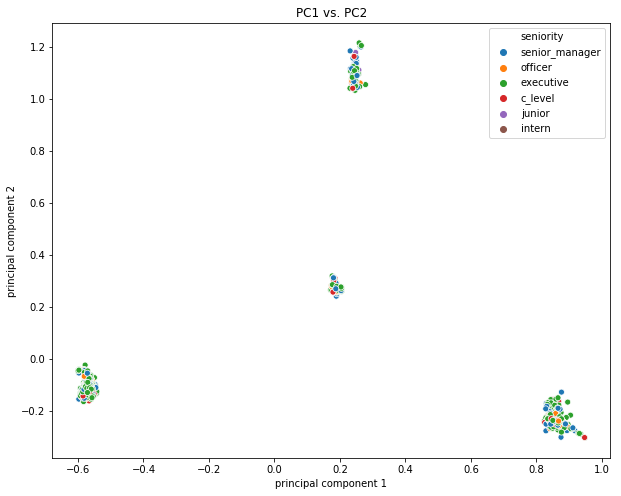

In [113]:
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x = 'PC1', y = 'PC2', data = df_pca, hue = 'seniority')

ax.set_title('PC1 vs. PC2')
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.show()

## Model Selection

There are two ways to perform salary prediction. 

**Perform a linear regression prediction model.**
Here, I test out the following models 
- **Base Model:** LinearRegression
- **Regularization Models** Ridge, Lasso
- **Robust Models** HuberRegressor

**Base Model**
--

In [114]:
def model_selection(model,X, y, xt, yt):
    kf = KFold(n_splits=5)
    lr = model()
    scores = cross_val_score(lr, X,y, cv = kf, scoring = 'r2')
    lr = lr.fit(X,y)
    y_pred = lr.predict(xt)
        
    print('Mean R2 :', round(np.mean(scores),2), 'Std R2:', round(np.std(scores),2))
    print('R2 Score ', round(r2_score(yt, y_pred),2))

model_selection(LinearRegression, X_train, y_train, X_test, y_test)

Mean R2 : -2.1434684724473434e+24 Std R2: 1.9393930714968617e+24
R2 Score  -8.798549921453071e+24


**Model 2 : Regularization Model**
---

In [115]:
def model_selection(model,X, y, xt, yt):
    
    for alpha in np.linspace(0.01,2,10): 
        
        kf = KFold(n_splits=10)
        mod = model(alpha = alpha, random_state = 42, max_iter = 1000)
        scores = cross_val_score(mod, X,y, cv = kf, scoring = 'r2')
        mod = mod.fit(X,y)
        y_pred = mod.predict(xt)
        
        print('alpha: ', round(alpha,2), 'Mean R2 :', round(np.mean(scores),2), 'Std R2:', round(np.std(scores),2))
        print('R2 Score ', round(r2_score(yt, y_pred),2))


#model_selection(Lasso,X_train, y_train, X_test, y_test) # Performance of Lasso is very low
model_selection(Ridge,X_train, y_train, X_test, y_test)


alpha:  0.01 Mean R2 : 0.66 Std R2: 0.07
R2 Score  0.69
alpha:  0.23 Mean R2 : 0.68 Std R2: 0.06
R2 Score  0.71
alpha:  0.45 Mean R2 : 0.68 Std R2: 0.05
R2 Score  0.71
alpha:  0.67 Mean R2 : 0.68 Std R2: 0.05
R2 Score  0.71
alpha:  0.89 Mean R2 : 0.68 Std R2: 0.05
R2 Score  0.7
alpha:  1.12 Mean R2 : 0.68 Std R2: 0.05
R2 Score  0.7
alpha:  1.34 Mean R2 : 0.67 Std R2: 0.05
R2 Score  0.7
alpha:  1.56 Mean R2 : 0.67 Std R2: 0.05
R2 Score  0.69
alpha:  1.78 Mean R2 : 0.67 Std R2: 0.05
R2 Score  0.69
alpha:  2.0 Mean R2 : 0.66 Std R2: 0.05
R2 Score  0.68


In [116]:
rdge = Ridge(alpha = 0.67, random_state = 42, max_iter = 1000)
rdge = rdge.fit(X_train,y_train)
y_pred = rdge.predict(X_test)

In [117]:
print('R2 Score ', round(r2_score(y_test, y_pred),2))

R2 Score  0.71


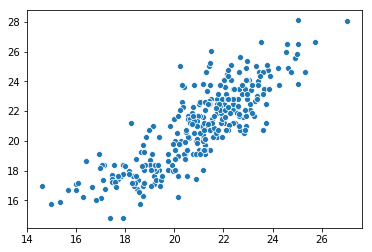

In [118]:
sns.scatterplot(x = y_pred, y = y_test)

In [120]:
## extract coefficients
values = pd.DataFrame(rdge.coef_, columns = ['coefs'])
values['Features'] = new_df_in.columns

In [121]:
print('Top Features that positively impact salary')
print('------------------------------------------')
values.sort_values(by = 'coefs', ascending = False).head(10)

Top Features that positively impact salary
------------------------------------------


,coefs,Features
1856,3.946147,vp
578,2.625055,director
159,1.944770,architect
1253,1.928726,principal
709,1.920140,financial controller
153518,1.639633,marine
988,1.620099,management
117629,1.592855,risk
752,1.566245,global
153086,1.450216,datarobot singapore


In [122]:
print('Top Features that negatively impact salary')
print('------------------------------------------')
values.sort_values(by = 'coefs', ascending = False).tail(10)

Top Features that negatively impact salary
------------------------------------------


,coefs,Features
189,-1.778232,assistant professor
1299,-1.778232,professor
153083,-1.790522,data
336,-1.841865,clerk
153963,-1.857948,training
421,-1.948402,coordinator
154005,-1.980468,urbanfox
664,-2.253018,executive
3,-3.000552,seniority_officer
1,-3.880283,seniority_intern


In [123]:
## Predicting Salaries for Indeed.com

X_in = new_df_in.iloc[1576:,:]

y_pred_in = rdge.predict(X_in.values)

In [124]:
df['predicted_salary'] = y_pred_in

In [145]:
## Show the differences 

print('Mean Salaries per Seniority MyCareersFuture.com ')
print(' -------------- ')
print(df_mcf.groupby('seniority')[['mean_salaries_bc']].agg(['mean', 'std']))
print(' -------------- ')
print('Mean Salaries per Seniority Indeed.com ')
print(' -------------- ')
print(df.groupby('seniority')[['predicted_salary']].agg(['mean', 'std']))

Mean Salaries per Seniority MyCareersFuture.com 
 -------------- 
               mean_salaries_bc          
                           mean       std
seniority                                
c_level               23.577437  3.477228
executive             20.635369  2.350722
intern                14.456021  1.898940
junior                20.213092  1.304574
officer               17.442016  1.638369
senior_manager        22.432728  2.022835
 -------------- 
Mean Salaries per Seniority Indeed.com 
 -------------- 
               predicted_salary          
                           mean       std
seniority                                
c_level               23.491996  1.508389
executive             21.045775  1.146005
intern                17.949195  0.777786
junior                20.787999  0.574486
officer               18.057428  1.080273
senior_manager        22.616396  1.056708


In [146]:
## Show the differences 

print('Mean Salaries per Job Type MyCareersFuture.com ')
print(' -------------- ')
print(df_mcf.groupby('title_short')[['mean_salaries_bc']].agg(['mean', 'std']))
print(' -------------- ')
print('Mean Salaries per Job Type Indeed.com ')
print(' -------------- ')
print(df.groupby('title_short')[['predicted_salary']].agg(['mean', 'std']))

Mean Salaries per Job Type MyCareersFuture.com 
 -------------- 
                  mean_salaries_bc          
                              mean       std
title_short                                 
BA_&_consultant          21.742903  2.590985
academics                20.241602  1.891934
administration           19.026627  3.189317
data_job                 21.892209  2.193911
finances                 20.628987  3.006052
management               22.243755  2.258915
other_tech_career        21.379499  2.253082
unclassified             20.041324  2.754108
 -------------- 
Mean Salaries per Job Type Indeed.com 
 -------------- 
                  predicted_salary          
                              mean       std
title_short                                 
BA_&_consultant          21.589353  1.824914
academics                20.585871  1.962598
administration           20.086955  2.125270
data_job                 21.727395  1.423972
finances                 21.910817  1.886212
managem

**Model 2 - HuberRegressor**
----

In [128]:
def model_selection(X, y, xt, yt):
    parameters = {'epsilon' : np.linspace(1,10,5), 'alpha' : np.linspace(0.01,1,5)}
    model = HuberRegressor()
    hr = GridSearchCV(model, parameters, cv = 3,n_jobs = -1, scoring = 'r2', verbose = 3)
    hr = hr.fit(X,y)
    print(hr.best_score_)
    print(hr.best_params_)

model_selection(X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 40.4min finished


0.6614660373286511
{'alpha': 1.0, 'epsilon': 3.25}


In [222]:
kf = KFold(n_splits=3)
mod = HuberRegressor(epsilon = 3.25, alpha = 1)
scores = cross_val_score(mod, X_train,y_train, cv = kf, scoring = 'r2')
mod = mod.fit(X_train,y_train)
y_pred_hr = mod.predict(X_test)
        
print('Mean R2 :', round(np.mean(scores),2), 'Std R2:', round(np.std(scores),2))
print('R2 Score ', round(r2_score(y_test, y_pred),2))

Mean R2 : 0.66 Std R2: 0.02
R2 Score  0.71


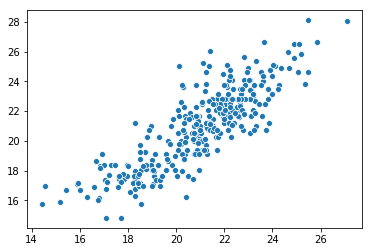

In [223]:
sns.scatterplot(x = y_pred_hr, y = y_test)

In [224]:
## extract coefficients
values_hr = pd.DataFrame(mod.coef_, columns = ['coefs'])
values_hr['Features'] = new_df_in.columns

In [225]:
print('Top Features that positively impact salary')
print('------------------------------------------')
values_hr.sort_values(by = 'coefs', ascending = False).head(10)

Top Features that positively impact salary
------------------------------------------


,coefs,Features
1856,4.469866,vp
578,2.955715,director
1253,2.432059,principal
709,2.194852,financial controller
159,1.955334,architect
117629,1.946100,risk
153518,1.921748,marine
752,1.875531,global
463,1.771011,customer success
988,1.767721,management


In [226]:
print('Top Features that negatively impact salary')
print('------------------------------------------')
values_hr.sort_values(by = 'coefs', ascending = False).tail(10)

Top Features that negatively impact salary
------------------------------------------


,coefs,Features
336,-1.985482,clerk
664,-2.035649,executive
421,-2.045223,coordinator
153963,-2.103935,training
153083,-2.109809,data
1299,-2.195731,professor
189,-2.195731,assistant professor
154005,-2.490505,urbanfox
3,-2.698963,seniority_officer
1,-4.389779,seniority_intern


In [227]:
## Predicting Salaries for Indeed.com
y_pred_in_hr = mod.predict(X_in.values)

In [228]:
df['predicted_salary'] = y_pred_in

In [229]:
print('Mean Salaries per Seniority MyCareersFuture.com ')
print(' -------------- ')
print(df_mcf.groupby('seniority')[['mean_salaries_bc']].agg(['mean', 'std']))
print(' -------------- ')
print('Mean Salaries per Seniority Indeed.com ')
print(' -------------- ')
print(df.groupby('seniority')[['predicted_salary']].agg(['mean', 'std']))

Mean Salaries per Seniority MyCareersFuture.com 
 -------------- 
               mean_salaries_bc          
                           mean       std
seniority                                
c_level               23.577437  3.477228
executive             20.635369  2.350722
intern                14.456021  1.898940
junior                20.213092  1.304574
officer               17.442016  1.638369
senior_manager        22.432728  2.022835
 -------------- 
Mean Salaries per Seniority Indeed.com 
 -------------- 
               predicted_salary          
                           mean       std
seniority                                
c_level               23.491996  1.508389
executive             21.045775  1.146005
intern                17.949195  0.777786
junior                20.787999  0.574486
officer               18.057428  1.080273
senior_manager        22.616396  1.056708


In [230]:
print('Mean Salaries per Job Type MyCareersFuture.com ')
print(' -------------- ')
print(df_mcf.groupby('title_short')[['mean_salaries_bc']].agg(['mean', 'std']))
print(' -------------- ')
print('Mean Salaries per Job Type Indeed.com ')
print(' -------------- ')
print(df.groupby('title_short')[['predicted_salary']].agg(['mean', 'std']))

Mean Salaries per Job Type MyCareersFuture.com 
 -------------- 
                  mean_salaries_bc          
                              mean       std
title_short                                 
BA_&_consultant          21.742903  2.590985
academics                20.241602  1.891934
administration           19.026627  3.189317
data_job                 21.892209  2.193911
finances                 20.628987  3.006052
management               22.243755  2.258915
other_tech_career        21.379499  2.253082
unclassified             20.041324  2.754108
 -------------- 
Mean Salaries per Job Type Indeed.com 
 -------------- 
                  predicted_salary          
                              mean       std
title_short                                 
BA_&_consultant          21.589353  1.824914
academics                20.585871  1.962598
administration           20.086955  2.125270
data_job                 21.727395  1.423972
finances                 21.910817  1.886212
managem

### Best Model : Ridge Regression

**Findings:** Salaries are mostly impacted by the seniority of the job. I.e Interns earn less than Senior and C-level personnel. 

### Question 2: Factors that distinguish job category
Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:

What components of a job posting distinguish data scientists from other data jobs?
What features are important for distinguishing junior vs. senior positions?
Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?
You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

---


## Strategy:
--------------
**What features distingish data jobs versus other jobs** 

- TARGET DATA : Short Job Title
    - Convert Short job titles into binary
    - Data Job = 1
    - Others = 0

- Keep same NLP as above. 

- Perform Smote on Data Jobs to balance classes

- Model Selection 
    - KNN (classification)
    - Logistic Regression (Regression)
    - Adaboost(Classification)


- If a model is good, identify important features via coeficient values

In [318]:
# MY CAREERS FUTURE.COM DATAFRAME WITHOUT JOB TITLES
#Dummify the seniority:
categories = df_mcf[['seniority']]
categories = pd.get_dummies(categories, drop_first = True)

#Reset all indexes
categories.reset_index(drop = True, inplace = True)
d_trans.reset_index(drop = True, inplace = True)
co_trans.reset_index(drop = True, inplace = True)

salaries = df_mcf['mean_salaries_bc']
salaries.reset_index(drop = True, inplace = True)

#Concatenate all the dataframes
new_df = pd.concat([categories, d_trans, co_trans, salaries], axis = 1)
print('Number of Columns for mycareersfuture.com : {}'.format(new_df.shape[1]))

Number of Columns for mycareersfuture.com : 88385


**Convert Job Titles to binary**
--

In [319]:
new_df['jb_title'] = df_mcf['title_short']

In [320]:
new_df['jb_title'] = new_df['jb_title'] .apply(lambda x: 1 if x=='data_job' else 0)

In [321]:
print('0 = Non data job, 1 = Data job')
new_df['jb_title'].value_counts()

0 = Non data job, 1 = Data job


0    1250
1     326
Name: jb_title, dtype: int64

In [322]:
X = new_df.drop(columns = 'jb_title')
y = new_df['jb_title']

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 42)

**Balancing Classes Using Smote**
---

In [323]:
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_sample(X_train, y_train)

**K-Nearest Neighbours**
---

In [324]:
def model_selection(X, y, xt, yt):
    for k in [1,2,4,6,8,10,20]:
        mod = KNeighborsClassifier(n_neighbors= k)
        scores = cross_val_score(mod, X,y, cv = 5, scoring = 'accuracy')
        mod = mod.fit(X,y)
        y_pred = mod.predict(xt)
        
        print('Mean accuracy :', round(np.mean(scores),2), 'Std accuracy:', round(np.std(scores),2))
        print('confusion matrix ', confusion_matrix(yt, y_pred))
        
model_selection(x_res, y_res, X_test, y_test)

Mean accuracy : 0.71 Std accuracy: 0.01
confusion matrix  [[117 130]
 [ 13  56]]
Mean accuracy : 0.73 Std accuracy: 0.02
confusion matrix  [[127 120]
 [ 14  55]]
Mean accuracy : 0.68 Std accuracy: 0.02
confusion matrix  [[ 93 154]
 [  6  63]]
Mean accuracy : 0.66 Std accuracy: 0.02
confusion matrix  [[ 82 165]
 [  5  64]]
Mean accuracy : 0.64 Std accuracy: 0.02
confusion matrix  [[ 78 169]
 [  6  63]]
Mean accuracy : 0.64 Std accuracy: 0.02
confusion matrix  [[ 75 172]
 [  5  64]]
Mean accuracy : 0.62 Std accuracy: 0.02
confusion matrix  [[ 69 178]
 [  2  67]]


**Logistic Regression**
---

In [325]:
def model_selection(X, y, xt, yt):
    for c in [0.001, 0.01, 0.1, 1, 10, 100]:
        mod = LogisticRegression(C = c, solver = 'lbfgs', max_iter = 1000)
        scores = cross_val_score(mod, X,y, cv = 5, scoring = 'accuracy')
        mod = mod.fit(X,y)
        y_pred = mod.predict(xt)
        
        print('Mean accuracy :', round(np.mean(scores),2), 'Std accuracy:', round(np.std(scores),2))
        print('confusion matrix ', confusion_matrix(yt, y_pred))
        
model_selection(x_res, y_res, X_test, y_test)

Mean accuracy : 0.62 Std accuracy: 0.01
confusion matrix  [[146 101]
 [ 24  45]]
Mean accuracy : 0.66 Std accuracy: 0.01
confusion matrix  [[157  90]
 [ 22  47]]
Mean accuracy : 0.78 Std accuracy: 0.02
confusion matrix  [[180  67]
 [ 19  50]]
Mean accuracy : 0.92 Std accuracy: 0.02
confusion matrix  [[224  23]
 [ 25  44]]
Mean accuracy : 0.95 Std accuracy: 0.02
confusion matrix  [[235  12]
 [ 30  39]]
Mean accuracy : 0.96 Std accuracy: 0.01
confusion matrix  [[239   8]
 [ 33  36]]


**Best Model: Logistic Regression**
---

In [335]:
mod = LogisticRegression(C = 1, solver = 'lbfgs', max_iter = 1000)
mod = mod.fit(x_res,y_res)
y_pred = mod.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[224,  23],
       [ 25,  44]])

In [336]:
## extract coefficients
values_log = pd.DataFrame(mod.coef_[0], columns = ['coefs'])
values_log['Features'] = X.columns

In [337]:
print('Top Features that dictate data job title positively')
print('------------------------------------------')
values_log.sort_values(by = 'coefs', ascending = False).head(10)

Top Features that dictate data job title positively
------------------------------------------


,coefs,Features
17655,5.313159,data
3970,2.390649,analytics
9122,2.270947,business
3484,1.880218,analysis
18732,1.843522,database
3798,1.785866,analyst
43324,1.668906,machine
43328,1.594269,machine learning
2,1.458919,seniority_junior
41551,1.395447,learning


In [338]:
print('Top Features that dictate data job title negatively')
print('------------------------------------------')
values_log.sort_values(by = 'coefs', ascending = False).tail(10)

Top Features that dictate data job title negatively
------------------------------------------


,coefs,Features
71872,-0.818540,software
45600,-0.823202,marketing
87825,-0.842498,group
84531,-0.851697,web
810,-0.872898,account
20583,-0.971606,design
88248,-0.992264,starhub
87753,-1.025728,engineering
88338,-1.158023,university
87958,-1.172038,limited


**AdaBoost**
---

In [329]:
clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5000), n_estimators=20, random_state=42)
scores = cross_val_score(clf, x_res,y_res, cv = 3, scoring = 'accuracy')
clf = clf.fit(x_res,y_res)
y_pred = clf.predict(X_test)

print('Mean accuracy :', round(np.mean(scores),2), 'Std accuracy:', round(np.std(scores),2))
print('confusion matrix ', confusion_matrix(y_test, y_pred))

Mean accuracy : 0.87 Std accuracy: 0.06
confusion matrix  [[215  32]
 [ 25  44]]


In [330]:
## extract coefficients
feature_imp = pd.DataFrame(clf.feature_importances_, columns = ['coefs'])
feature_imp['Features'] = X.columns

In [333]:
print('Top Features that dictate job title')
print('------------------------------------------')
feature_imp.sort_values(by = 'coefs', ascending = False).head(20)

Top Features that dictate job title
------------------------------------------


,coefs,Features
17655,0.315439,data
3798,0.123337,analyst
9122,0.048222,business
84149,0.032370,visualization
81761,0.021020,tuning
9784,0.020986,bw
66082,0.020123,responsibility scope
53219,0.016141,passionate
87040,0.013686,year
18948,0.012220,day


## Strategy # 2:
--------------
**What features distinguish seniority** 

- TARGET DATA : Job Seniority
    - Convert Job Seniority into binary
    - Senior Job = 1
    - Lower Job = 0

- Keep same NLP as above. 

- Perform Smote on seniority to balance classes

- Model Selection 
    - KNN (classification)
    - Logistic Regression (Regression)

- If a model is good, identify important features via coeficient values

In [285]:
# MY CAREERS FUTURE.COM DATAFRAME WITHOUT SENIORITY

#Reset all indexes

d_trans.reset_index(drop = True, inplace = True)
jb_trans.reset_index(drop = True, inplace = True)
co_trans.reset_index(drop = True, inplace = True)

salaries = df_mcf['mean_salaries_bc']
salaries.reset_index(drop = True, inplace = True)

#Concatenate all the dataframes
new_df = pd.concat([d_trans, jb_trans, co_trans, salaries], axis = 1)
print('Number of Columns for mycareersfuture.com : {}'.format(new_df.shape[1]))

Number of Columns for mycareersfuture.com : 89525


**Convert Seniority to binary**
--

In [292]:
df_mcf.reset_index(drop = True, inplace = True)

In [293]:
new_df['seniority'] = df_mcf['seniority']

In [295]:
new_df['seniority'].value_counts()

executive         833
senior_manager    487
officer           161
c_level            75
junior             17
intern              3
Name: seniority, dtype: int64

In [296]:
for a in ['c_level', 'senior_manager']:
    new_df['seniority'] = new_df['seniority'].apply(lambda x: 1 if x==a else x)

for a in ['executive','officer', 'junior', 'intern']:
    new_df['seniority'] = new_df['seniority'].apply(lambda x: 0 if x==a else x)

print('Senior = 1, Lower = 0')
new_df['seniority'].value_counts()

Senior = 1, Lower = 0


0    1014
1     562
Name: seniority, dtype: int64

In [297]:
X = new_df.drop(columns = 'seniority')
y = new_df['seniority']

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 42)

**Balancing Classes Using Smote**
---

In [299]:
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_sample(X_train, y_train)

**K-Nearest Neighbours**
---

In [300]:
def model_selection(X, y, xt, yt):
    for k in [1,2,4,6,8,10,20]:
        mod = KNeighborsClassifier(n_neighbors= k)
        scores = cross_val_score(mod, X,y, cv = 5, scoring = 'accuracy')
        mod = mod.fit(X,y)
        y_pred = mod.predict(xt)
        
        print('Mean accuracy :', round(np.mean(scores),2), 'Std accuracy:', round(np.std(scores),2))
        print('confusion matrix ', confusion_matrix(yt, y_pred))
        
model_selection(x_res, y_res, X_test, y_test)

Mean accuracy : 0.74 Std accuracy: 0.03
confusion matrix  [[104 103]
 [ 11  98]]
Mean accuracy : 0.76 Std accuracy: 0.04
confusion matrix  [[119  88]
 [ 19  90]]
Mean accuracy : 0.69 Std accuracy: 0.03
confusion matrix  [[ 89 118]
 [ 11  98]]
Mean accuracy : 0.67 Std accuracy: 0.03
confusion matrix  [[ 74 133]
 [  7 102]]
Mean accuracy : 0.67 Std accuracy: 0.03
confusion matrix  [[ 71 136]
 [  7 102]]
Mean accuracy : 0.66 Std accuracy: 0.02
confusion matrix  [[ 71 136]
 [  7 102]]
Mean accuracy : 0.66 Std accuracy: 0.02
confusion matrix  [[ 75 132]
 [  6 103]]


**Logistic Regression**
---

In [301]:
def model_selection(X, y, xt, yt):
    for c in [0.001, 0.01, 0.1, 1, 10, 100]:
        mod = LogisticRegression(C = c, solver = 'lbfgs', max_iter = 1000)
        scores = cross_val_score(mod, X,y, cv = 5, scoring = 'accuracy')
        mod = mod.fit(X,y)
        y_pred = mod.predict(xt)
        
        print('Mean accuracy :', round(np.mean(scores),2), 'Std accuracy:', round(np.std(scores),2))
        print('confusion matrix ', confusion_matrix(yt, y_pred))
        
model_selection(x_res, y_res, X_test, y_test)

Mean accuracy : 0.7 Std accuracy: 0.02
confusion matrix  [[132  75]
 [ 43  66]]
Mean accuracy : 0.72 Std accuracy: 0.02
confusion matrix  [[142  65]
 [ 40  69]]
Mean accuracy : 0.86 Std accuracy: 0.03
confusion matrix  [[179  28]
 [ 23  86]]
Mean accuracy : 0.96 Std accuracy: 0.02
confusion matrix  [[198   9]
 [ 11  98]]
Mean accuracy : 0.98 Std accuracy: 0.01
confusion matrix  [[206   1]
 [  4 105]]
Mean accuracy : 0.98 Std accuracy: 0.01
confusion matrix  [[207   0]
 [  2 107]]


**Best Model: Logistic Regression**
---

In [304]:
mod = LogisticRegression(C = 100, solver = 'lbfgs', max_iter = 1000)
mod = mod.fit(x_res,y_res)
y_pred = mod.predict(X_test)

In [316]:
confusion_matrix(y_test, y_pred)

array([[207,   0],
       [  2, 107]])

In [317]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.9907407407407407

In [313]:
## extract coefficients
values_log = pd.DataFrame(mod.coef_[0], columns = ['coefs'])
values_log['Features'] = X.columns

In [314]:
print('Top Features that dictate job seniority positively')
print('------------------------------------------')
values_log.sort_values(by = 'coefs', ascending = False).head(10)

Top Features that dictate job seniority positively
------------------------------------------


,coefs,Features
88384,26.550485,senior
88082,21.544578,manager
88042,12.119991,lead
87713,10.097270,coordinator
88494,6.746350,sr
87954,6.584571,head
87823,4.879248,director
88429,4.817665,senior software
87602,4.011917,avp
88402,3.891508,senior executive


In [315]:
print('Top Features that dictate job seniority negatively')
print('------------------------------------------')
values_log.sort_values(by = 'coefs', ascending = False).tail(10)

Top Features that dictate job seniority negatively
------------------------------------------


,coefs,Features
88629,-2.323404,accenture
87907,-2.429048,financial controller
87689,-2.567609,consultant
87673,-2.692288,cloud
87811,-3.033048,developer
87487,-3.131840,accountant
87561,-3.247494,architect
87837,-4.531941,engineer
88480,-4.594651,specialist
87528,-5.538630,analyst
